1) Prepare and import data

In [44]:
import pandas as pd
import numpy as np
import scipy.stats
from os import chdir
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn') # Set style for document to plot graphs in the seaborn style

chdir('C:/Users/kmorg/OneDrive - Universiteit Leiden/School/MFAII/Final/') # Change directories to your directory if necessary
path = "data/"

#Land_use_data
NL_land_use_data_1950_1989 = pd.read_csv(f'{path}1950_1990_data_extrapolated.csv', delimiter=',') # Data extrapolated from a graph in a document using plotdigitizer.com - Source: https://edepot.wur.nl/25730
NL_land_use_data_1950_1997_veg = pd.read_csv(f'{path}1950_2000_data_extrapolated_veg.csv', delimiter=',') # Data extrapolated from a graph in a document using plotdigitizer.com - Source: https://edepot.wur.nl/25730
NL_land_use_data_1987_1999 = pd.read_excel(f'{path}underglass_1987_1999.xls', sheet_name='Sheet1') #Source https://historisch.cbs.nl/
NL_land_use_data_2000_2022 = pd.read_csv(f'{path}Agriculture__general_farm_type__region_14062023_133617.csv', delimiter=';') # Source: https://opendata.cbs.nl/#/CBS/en/dataset/80783eng/table?dl=918B8

#Material intensities
material_intensities_Theurl_2008 = pd.read_excel(f'{path}material_intensities.xls', sheet_name='Theurl 2008', index_col= 0) # Source: https://www.aau.at/wp-content/uploads/2016/11/working-paper-110-web.pdf
material_intensities_Anton_etal_2012  = pd.read_excel(f'{path}material_intensities.xls', sheet_name='Anton et al. 2012', index_col=[0,1]) #Source: https://doi.org/10.17660/ActaHortic.2012.927.97

#Scenario development 
NL_gross_vegetable_yield_1998_2022 = pd.read_csv(f'{path}Vegetables__yield_per_kind_of_vegetable_16062023_065748.csv', delimiter=';') # Source: https://opendata.cbs.nl/#/CBS/en/dataset/37738ENG/table?dl=54486
NL_population_projections_2070 = pd.read_csv(f'{path}Population, 1 January (x million).csv', delimiter=';') # Source: https://www.cbs.nl/en-gb/visualisations/dashboard-population/population-dynamics/population-in-the-future
NL_vegetable_exports_1961_2021 = pd.read_csv(f'{path}FAOSTAT_data_en_vegetable_exports.csv', delimiter=',') # Source: https://www.fao.org/faostat/en/#data/TCL Filter : 'Total - vegetables'

#Code by Kevin Morgan-Rothschild (C) 2023 created for MFAII course final project 
#Stock driven models and Montecarlo simulation are adapted from models created by Tomer Fishman
#ChapGPT was used partialy to facilitate the coding process

2) Prepare 1950-1989 dataset

In [2]:
NL_land_use_data_1950_1989['Periods'] = NL_land_use_data_1950_1989['Periods'].apply(round) #rounds all data values to the nearest whole number 
NL_land_use_data_1950_1989 = NL_land_use_data_1950_1989.groupby('Periods')['Greenhouse surface (ha)'].mean().reset_index() #Averages duplicates

values_to_test = NL_land_use_data_1950_1989['Periods'].tolist()

start_year = 1950
end_year = 1989

expected_values = list(range(start_year, end_year + 1))

# Find the missing values by comparing the expected values
missing_values = [year for year in expected_values if year not in values_to_test]

for missing_value in missing_values:
    before_row = NL_land_use_data_1950_1989[NL_land_use_data_1950_1989['Periods'] == missing_value - 1]
    after_row = NL_land_use_data_1950_1989[NL_land_use_data_1950_1989['Periods'] == missing_value + 1]

    # Get the values of 'Greenhouse surface (ha)' for the before and after rows
    before_value = before_row['Greenhouse surface (ha)'].values[0]
    after_value = after_row['Greenhouse surface (ha)'].values[0]

    # Calculate the average of the before and after values
    average_value = (before_value + after_value) / 2

    # Fill in the missing value with the calculated average
    new_row = pd.DataFrame({'Periods': [missing_value], 'Greenhouse surface (ha)': [average_value]})
    NL_land_use_data_1950_1989 = pd.concat([NL_land_use_data_1950_1989, new_row], ignore_index=True).sort_values(by='Periods')# Append the new row to the DataFrame

In [3]:
# Prepare veg data
NL_land_use_data_1950_1997_veg['Periods'] = NL_land_use_data_1950_1997_veg['Periods'].apply(round) #rounds all data values to the nearest whole number 
NL_land_use_data_1950_1997_veg = NL_land_use_data_1950_1997_veg.groupby('Periods')['Greenhouse surface (ha)'].mean().reset_index() #Averages duplicates

values_to_test = NL_land_use_data_1950_1997_veg['Periods'].tolist()

start_year = 1950
end_year = 1997

expected_values = list(range(start_year, end_year + 1))

# Find the missing values by comparing the expected values
missing_values = [year for year in expected_values if year not in values_to_test]

for missing_value in missing_values:
    before_row = NL_land_use_data_1950_1997_veg[NL_land_use_data_1950_1997_veg['Periods'] == missing_value - 1]
    after_row = NL_land_use_data_1950_1997_veg[NL_land_use_data_1950_1997_veg['Periods'] == missing_value + 1]

    # Get the values of 'Greenhouse surface (ha)' for the before and after rows
    before_value = before_row['Greenhouse surface (ha)'].values[0]
    after_value = after_row['Greenhouse surface (ha)'].values[0]

    # Calculate the average of the before and after values
    average_value = (before_value + after_value) / 2

    # Fill in the missing value with the calculated average
    new_row = pd.DataFrame({'Periods': [missing_value], 'Greenhouse surface (ha)': [average_value]})
    NL_land_use_data_1950_1997_veg = pd.concat([NL_land_use_data_1950_1997_veg, new_row], ignore_index=True).sort_values(by='Periods')# Append the new row to the DataFrame

3) Convert land under glass to material

In [4]:
#3.A) Extract the desired columns from each DataFrame
data_1950_1986 = NL_land_use_data_1950_1989['Greenhouse surface (ha)'][:-3]
data_1987_1999 = NL_land_use_data_1987_1999['Greenhouse surface (ha)']
data_2000_2022 = NL_land_use_data_2000_2022['Horticulture, under glass/Area/Horticulture under glass, total (m2)'] / 10000 # to convert from m2 to ha 

#Extract data for vegetable only production
data_1950_1997_veg = NL_land_use_data_1950_1997_veg['Greenhouse surface (ha)'][:-3]
NL_gross_vegetable_yield_1998_2022 = NL_gross_vegetable_yield_1998_2022[NL_gross_vegetable_yield_1998_2022['Vegetables'] == 'Vegetables under glass'] #only select rows 'Vegetables under glass'
data_1998_2022_veg = NL_gross_vegetable_yield_1998_2022['Cropping area (hectares)']

#Extract material intensities (Theurl 2008)
mi_steel = material_intensities_Theurl_2008.loc['Steel', 'Quantity (kg/ha)']
mi_concrete = material_intensities_Theurl_2008.loc['Concrete', 'Quantity (kg/ha)']
mi_glass = material_intensities_Theurl_2008.loc['Glass', 'Quantity (kg/ha)']
mi_aluminium = material_intensities_Theurl_2008.loc['Aluminium', 'Quantity (kg/ha)']

# Concatenate the columns vertically
NL_gh_stock_data_veg = pd.DataFrame()
NL_gh_stock_data = pd.DataFrame()

NL_gh_stock_data['Greenhouse surface (ha)'] = pd.concat([data_1950_1986, data_1987_1999, data_2000_2022],  ignore_index=True, axis=0) # Set up total surface
NL_gh_stock_data_veg['Greenhouse surface (ha) - veg'] = pd.concat([data_1950_1997_veg, data_1998_2022_veg],  ignore_index=True, axis=0) # Set up vegetable production
NL_gh_stock_data.reset_index(drop=True, inplace=True)
NL_gh_stock_data_veg.reset_index(drop=True, inplace=True)
NL_gh_stock_data = pd.concat([NL_gh_stock_data, NL_gh_stock_data_veg], axis=1,ignore_index=True) # Set up vegetable production
NL_gh_stock_data.rename(columns={0: 'Greenhouse surface (ha)',1: 'Greenhouse surface (ha) - veg'}, inplace=True)
NL_gh_stock_data['Greenhouse surface (ha) - flo'] = NL_gh_stock_data['Greenhouse surface (ha)'] - NL_gh_stock_data['Greenhouse surface (ha) - veg'] # Set up floriculture production

NL_gh_stock_data['Steel structure (kg) - Theurl'] = NL_gh_stock_data['Greenhouse surface (ha)'] * mi_steel
NL_gh_stock_data['Steel structure (kg) - Anton'] = NL_gh_stock_data['Greenhouse surface (ha)'] * material_intensities_Anton_etal_2012.loc[('Steel', 'Structure'), 'Quantity (kg/ha)']
NL_gh_stock_data['Steel all (kg) - Anton'] = NL_gh_stock_data['Greenhouse surface (ha)'] * material_intensities_Anton_etal_2012.loc[('Steel','Structure', slice(None)), 'Quantity (kg/ha)'].sum()

NL_gh_stock_data['Steel structure (kg) - Theurl - veg'] = NL_gh_stock_data['Greenhouse surface (ha) - veg'] * mi_steel
NL_gh_stock_data['Steel structure (kg) - Theurl - flo'] = NL_gh_stock_data['Greenhouse surface (ha) - flo'] * mi_steel

years = range(1950, 2023)
NL_gh_stock_data.index = years

# Prepare life times of steel

min_life_aluminium = material_intensities_Theurl_2008.loc['Aluminium', 'Min lifetime']
max_life_aluminium = material_intensities_Theurl_2008.loc['Aluminium', 'Max lifetime']

min_life_steel = material_intensities_Theurl_2008.loc['Steel', 'Min lifetime']
max_life_steel = material_intensities_Theurl_2008.loc['Steel', 'Max lifetime']

min_life_concrete = material_intensities_Theurl_2008.loc['Concrete', 'Min lifetime']
max_life_concerte = material_intensities_Theurl_2008.loc['Concrete', 'Max lifetime']

min_life_glass = material_intensities_Theurl_2008.loc['Steel', 'Min lifetime']
max_life_glass = material_intensities_Theurl_2008.loc['Steel', 'Max lifetime']


In [5]:
#3.B) Prepare input parameters

input_parameters = pd.DataFrame()
input_parameters.index = material_intensities_Theurl_2008.index
input_parameters = input_parameters[input_parameters.index != 'Polyester/Plexiglass']
input_parameters['mean'] = (material_intensities_Theurl_2008['Max lifetime'] + material_intensities_Theurl_2008['Min lifetime'])/2
input_parameters['standard_deviation'] = input_parameters['mean']/3


Text(0, 0.5, 'Surface area (ha)')

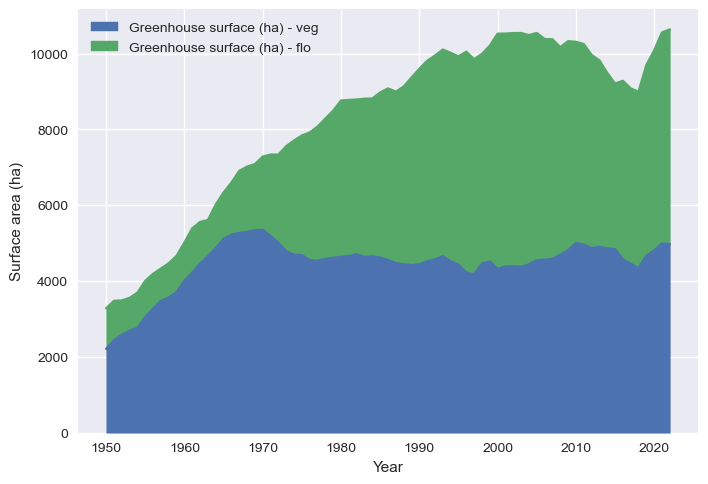

In [6]:
#3.C) Compare surface area vegetables versus floriculture

fig_surfacearea = NL_gh_stock_data.plot(kind="area", y = ['Greenhouse surface (ha) - veg', 'Greenhouse surface (ha) - flo'])
fig_surfacearea.set_xlabel('Year')
fig_surfacearea.set_ylabel('Surface area (ha)')

4) Prepare survival curve

In [7]:
def surv_curv(data_set, parameters_df, material):
    # Prepare time series
    time_max = data_set.shape[0]  # the final timestep of this timeseries # max_life_steel #
    timesteps = np.arange(0, time_max)  # an array of the timesteps

    #Normally distributed survival curve
    curve_sd = parameters_df.loc[material, "standard_deviation"]
    curve_surv = scipy.stats.norm.sf(timesteps, parameters_df.loc[material, "mean"], scale=curve_sd)
    return plt.plot(curve_surv), curve_surv, time_max, timesteps


5) Prepare survival curve matrix

In [8]:
def surv_curve_matrix(curve_surv, time_max, timesteps): 
    # create survival curve matrix with placeholder zeros
    curve_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps)

    # populate the survival curve matrix with shifted curves, column by column using slices
    for time in timesteps:
        curve_surv_matrix.loc[time:, time] = curve_surv[0:time_max - time]

    # Geometrically distributed survival curve for cohort 0, assumes 10% of the initial stock becomes outflow every year
    curve_depreciate = 0.10
    curve_surv_matrix[0] = scipy.stats.geom.sf(timesteps, curve_depreciate)
    return curve_surv_matrix

6) Prepare stock driven model

In [9]:
#6.A) Prepare function
def stock_model(data_set, curve_surv_matrix, plot_year, timesteps, material_units):
    stock_flow_timeseries = pd.DataFrame()
    stock_flow_timeseries.index = stock_flow_timeseries.index
    stock_flow_timeseries['stock'] = data_set
    stock_flow_timeseries['inflow'] = ''

    # create survival matrix with placeholder zeros
    cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps)
    stock_flow_timeseries['inflow'] = np.nan
    for time in timesteps:
        stock_flow_timeseries['inflow'].iloc[time] = (stock_flow_timeseries['stock'].iloc[time] - cohort_surv_matrix.loc[time, :].sum()) / curve_surv_matrix.loc[time, time]
        cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * stock_flow_timeseries['inflow'].iloc[time]

    cohort_surv_matrix.index = stock_flow_timeseries.index
    stock_flow_timeseries['nas'] = np.diff(stock_flow_timeseries['stock'], prepend=0)  # prepending 0 assumes no initial stock
    stock_flow_timeseries['outflow'] = stock_flow_timeseries['inflow'] - stock_flow_timeseries['nas']
    
    fig_flows = stock_flow_timeseries.loc[plot_year:].plot(kind='line', y=['inflow','nas','outflow'])
    fig_flows.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig_flows.set_xlabel('Year')
    fig_flows.set_ylabel(material_units)
    fig_cohorts = cohort_surv_matrix.loc[plot_year:].plot(kind="area", legend=False)
    fig_cohorts.set_xlabel('Year')
    fig_cohorts.set_ylabel(material_units)
    
    return stock_flow_timeseries, fig_flows, fig_cohorts

In [10]:
#6 B) Group together stock driven model components
def stock_driven_model(data_set, parameters_df, plot_year, material_units, material):
    plot_sc, curve_surv, time_max, timesteps = surv_curv(data_set, parameters_df, material)
    curve_surv_matrix = surv_curve_matrix(curve_surv, time_max, timesteps)
    stock_flow_timeseries, fig_flows, fig_cohorts  = stock_model(data_set, curve_surv_matrix, plot_year, timesteps, material_units)
    return stock_flow_timeseries, fig_flows, fig_cohorts

7.) Run all three modules 

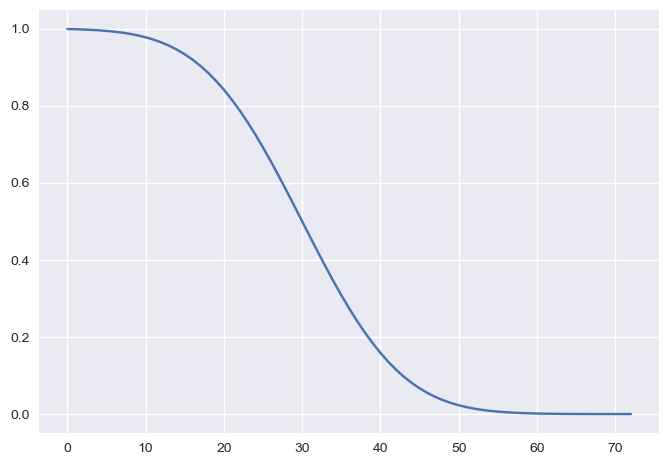

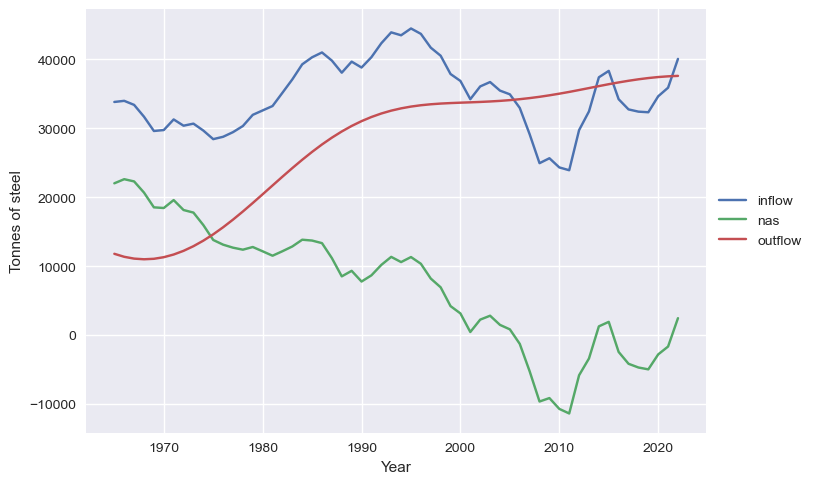

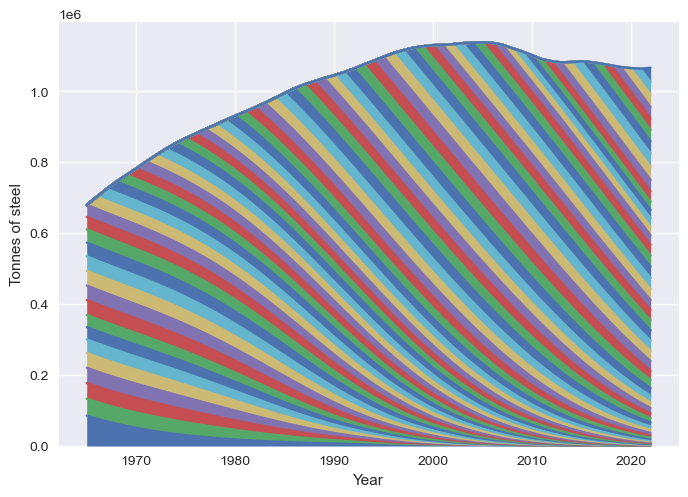

In [11]:
#Attention: This is a stock driven model for floriculture and vegetable production combined

NL_gh_stock_data['Steel structure (kg) - Theurl'] = NL_gh_stock_data['Steel structure (kg) - Theurl'].rolling(15, center=True, min_periods=1).mean()
bl_flow_timeseries, bl_fig_flows, bl_fig_cohorts = stock_driven_model((NL_gh_stock_data['Steel structure (kg) - Theurl']/1000), input_parameters, 1965, 'Tonnes of steel', 'Steel')

8) BAU scenario vegetable greenhouse stock development: Prepare yield and export projections

<AxesSubplot:xlabel='Periodes'>

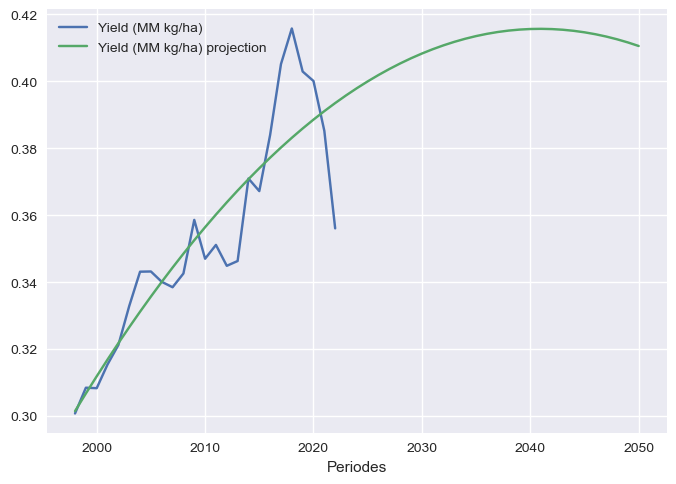

In [12]:
#8.A.) Prepare the yield/surface area projections
#Assumption that yield/surface area will keep growing

NL_gross_vegetable_yield_1998_2022['Yield (MM kg/ha)'] = NL_gross_vegetable_yield_1998_2022['Gross yield (mln kg)'] / NL_gross_vegetable_yield_1998_2022['Cropping area (hectares)']

# Extract the x and y values from the DataFrame
x_data = NL_gross_vegetable_yield_1998_2022['Periodes']
yield_data = NL_gross_vegetable_yield_1998_2022['Yield (MM kg/ha)'].values

# Choose the degree of the polynomial
degree = 2

# Perform polynomial fitting
coefficients = np.polyfit(x_data, yield_data, degree)

# Append to add the years 1998-2050
NL_gross_vegetable_yield_1998_2050 = pd.concat([NL_gross_vegetable_yield_1998_2022, pd.DataFrame({'Periodes': range(2023, 2051)})], ignore_index=True)# Append the new row to the DataFrame
x_data = NL_gross_vegetable_yield_1998_2050['Periodes']

# Generate the curve-fitted data
fitted_data = np.polyval(coefficients, x_data)

# Replace the 'inflow' column with the curve-fitted data
NL_gross_vegetable_yield_1998_2050['Yield (MM kg/ha) projection'] = fitted_data

NL_gross_vegetable_yield_1998_2050.plot(x= 'Periodes', y = ['Yield (MM kg/ha)', 'Yield (MM kg/ha) projection'])


<AxesSubplot:xlabel='Year'>

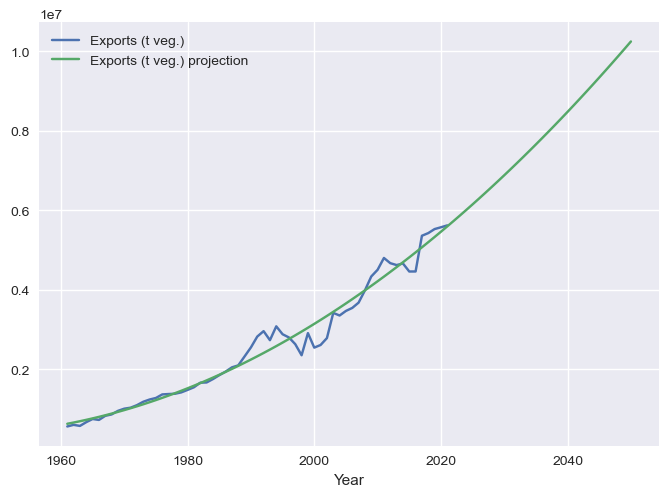

In [13]:
#8.B.) Prepare Dutch export projections
# Assumption is that export will follow the growth of current trends
dutch_made = 0.83 # % of goods exported that are not re-exported
NL_vegetable_exports_1961_2021_BL = NL_vegetable_exports_1961_2021.copy()
NL_vegetable_exports_1961_2021_BL = pd.read_csv('FAOSTAT_data_en_vegetable_exports.csv', delimiter=',') # Source: https://www.fao.org/faostat/en/#data/TCL Filter : 'Total - vegetables'
NL_vegetable_exports_1961_2021_BL = NL_vegetable_exports_1961_2021_BL[['Year', 'Value']]
NL_vegetable_exports_1961_2021_BL.rename(columns={'Value': 'Exports (t veg.)'}, inplace=True)
NL_vegetable_exports_1961_2021_BL['Exports (t veg.)'] *= dutch_made

# Extract the x and y values from the DataFrame
x_data = NL_vegetable_exports_1961_2021_BL['Year'].values
value_data = NL_vegetable_exports_1961_2021_BL['Exports (t veg.)'].values

# Choose the degree of the polynomial
degree = 2

# Perform polynomial fitting
coefficients = np.polyfit(x_data, value_data, degree)

# Append to add the years 2022-2050
NL_vegetable_exports_1961_2050 = pd.DataFrame()
NL_vegetable_exports_1961_2050 = pd.concat([NL_vegetable_exports_1961_2021_BL, pd.DataFrame({'Year': range(2022, 2051)})], ignore_index=True)
x_data = NL_vegetable_exports_1961_2050['Year'].values

# Generate the curve-fitted data
fitted_data = np.polyval(coefficients, x_data)

# Replace the 'inflow' column with the curve-fitted data
NL_vegetable_exports_1961_2050['Exports (t veg.) projection'] = fitted_data

NL_vegetable_exports_1961_2050.plot(x= 'Year', y = ['Exports (t veg.)', 'Exports (t veg.) projection'])


<AxesSubplot:xlabel='Year'>

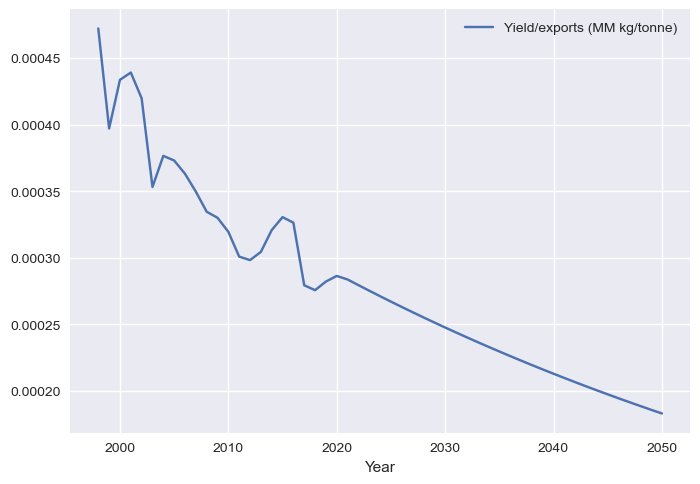

In [14]:
#8.C.) Prepare the yield/export projections
# Assumption that yield/export will decrease at 1.5% per year

NL_vegetable_exports_1961_2021 = pd.read_csv('FAOSTAT_data_en_vegetable_exports.csv', delimiter=',') # Source: https://www.fao.org/faostat/en/#data/TCL Filter : 'Total - vegetables'

NL_vegetable_yield_exports_1998_2021 = pd.DataFrame()
NL_vegetable_yield_exports_1998_2021['Year'] = NL_gross_vegetable_yield_1998_2022['Periodes'][:-1]
NL_vegetable_yield_exports_1998_2021['Gross yield (MM kg)'] = NL_gross_vegetable_yield_1998_2022['Gross yield (mln kg)'][:-1]
NL_vegetable_yield_exports_1998_2021['Exports (t veg.)'] = NL_vegetable_exports_1961_2021['Value'][37:61].values
NL_vegetable_yield_exports_1998_2021['Yield/exports (MM kg/tonne)'] =  NL_vegetable_yield_exports_1998_2021['Gross yield (MM kg)'] / NL_vegetable_yield_exports_1998_2021['Exports (t veg.)']


initial_value = NL_vegetable_yield_exports_1998_2021['Yield/exports (MM kg/tonne)'].iloc[-1]  # Get the last value in the column

# Create a list of new values with a 1.5% decrease from the previous value
new_values = [initial_value * (1 - 0.015) ** i for i in range(1, 30)]

# Create a DataFrame with the new values in a column called 'Value'
NL_vegetable_yield_exports_2022_2050 = pd.DataFrame({'Yield/exports (MM kg/tonne)': new_values})

NL_vegetable_yield_exports_2022_2050['Year'] = pd.DataFrame({'Year': range(2022, 2051)})

# Concatenate the new DataFrame with the original DataFrame
NL_vegetable_yield_exports_1998_2050 = pd.DataFrame()
NL_vegetable_yield_exports_1998_2050 = pd.concat([NL_vegetable_yield_exports_1998_2021, NL_vegetable_yield_exports_2022_2050], ignore_index=True)

NL_vegetable_yield_exports_1998_2050.plot(x= 'Year', y = ['Yield/exports (MM kg/tonne)'])

9.) Prepare SDA for BAU scenario for vegetable production greenhouses

In [15]:
#9.A.) BAU Scenario
BAU_scenario = pd.DataFrame()
BAU_scenario.name = 'BAU scenario'
#Prepare pop
BAU_scenario['Dutch population (MM)'] = pd.concat([NL_population_projections_2070['Observation'][16:].dropna(), NL_population_projections_2070['Forecast'][:-20].dropna()], axis=0,ignore_index=True)
BAU_scenario['Dutch population (MM)'] = BAU_scenario['Dutch population (MM)'].str.replace(',', '.').astype(float)

#Prepare exports
BAU_scenario['Exports (tonne)'] = pd.concat([NL_vegetable_exports_1961_2050['Exports (t veg.)'][37:61], NL_vegetable_exports_1961_2050['Exports (t veg.) projection'][-29:]], axis=0, ignore_index=True)

#Prepare exports/pop
BAU_scenario['Exports/Pop (tonnes/MM Dutch ppl)'] = BAU_scenario['Exports (tonne)']/ BAU_scenario['Dutch population (MM)']

#Prepare yield/exports
BAU_scenario['Yield/exports (MM kg/tonne)'] = NL_vegetable_yield_exports_1998_2050['Yield/exports (MM kg/tonne)']

#Prepare yield
BAU_scenario['Yield (MM kg)'] = BAU_scenario['Yield/exports (MM kg/tonne)']*BAU_scenario['Exports (tonne)']

#Prepare yield/stock
BAU_scenario['Yield/stock (MM kg veg./MM kg steel structure)'] = pd.concat([NL_gross_vegetable_yield_1998_2022['Yield (MM kg/ha)'], NL_gross_vegetable_yield_1998_2050['Yield (MM kg/ha) projection'][-29:]], axis=0, ignore_index=True) * (1/(material_intensities_Theurl_2008.loc['Steel', 'Quantity (kg/ha)']/1000000))

#Prepare stock
BAU_scenario['Stock (MM kg)'] = (BAU_scenario['Yield (MM kg)'] / BAU_scenario['Yield/stock (MM kg veg./MM kg steel structure)'])
BAU_scenario.index = NL_vegetable_yield_exports_1998_2050['Year']

In [16]:
#9.B) Prepare plotting function 

def plot_scenarios(dataframe):
    # Get the list of column names
    columns = dataframe.columns
    
    # Plot the first four columns on the first figure
    fig1, axes1 = plt.subplots(1, 4, figsize=(15, 5))
    for i, column in enumerate(columns[:4]):
        ax = axes1[i]
        ax.plot(dataframe.index, dataframe[column])
        ax.set_xlabel('Year')
        ax.set_ylabel(column)
        ax.set_ylim(0)
    plt.tight_layout()
    plt.show()
    
    # Plot the last three columns on the second figure
    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
    for i, column in enumerate(columns[-3:]):
        ax = axes2[i]
        ax.plot(dataframe.index, dataframe[column])
        ax.set_xlabel('Year')
        ax.set_ylabel(column)
        ax.set_ylim(0)
    plt.tight_layout()
    plt.show()

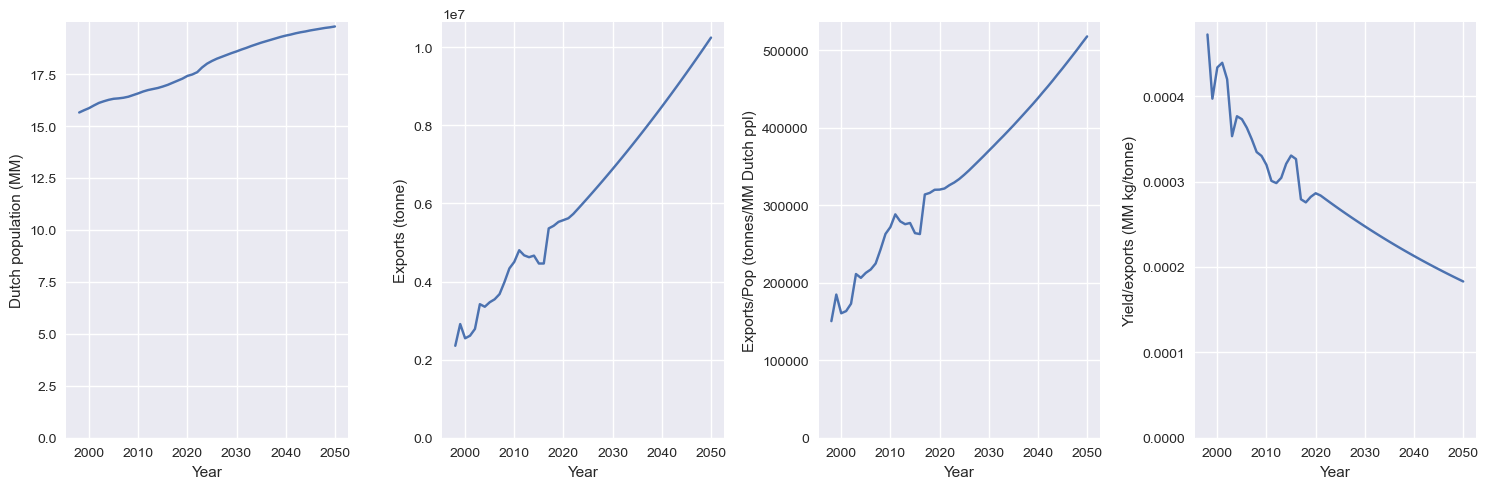

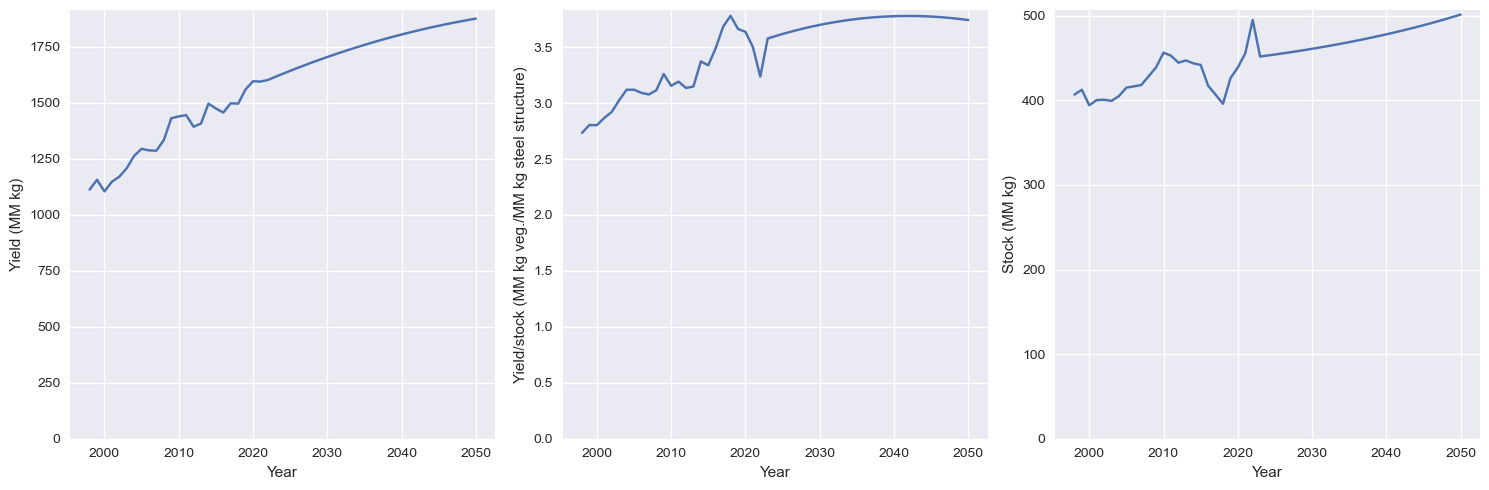

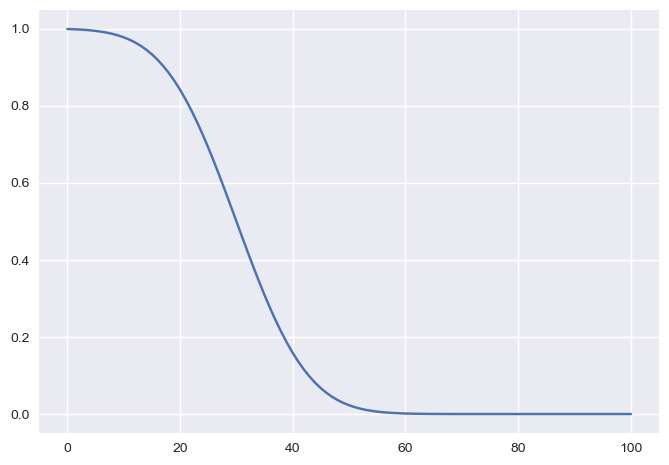

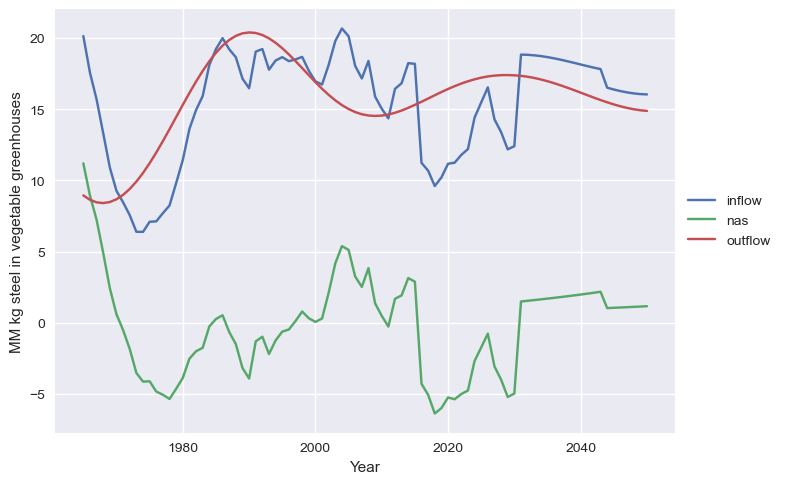

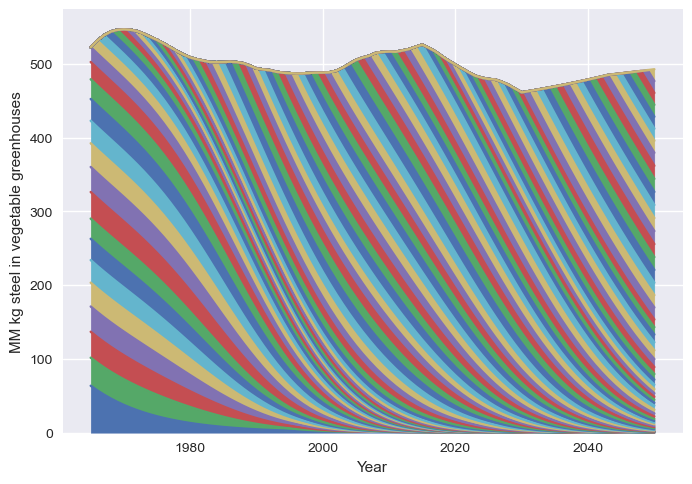

In [17]:
#9. C) Plot and run strock driven model
#BAU_scenario['Stock (MM kg)'] = BAU_scenario['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()

plot_scenarios(BAU_scenario)

BAU_scenario_ = pd.DataFrame()
BAU_scenario_['Stock (MM kg)'] = pd.concat([(NL_gh_stock_data['Steel structure (kg) - Theurl - veg']/1000000), BAU_scenario['Stock (MM kg)'][-28:]], axis=0)
BAU_scenario_['Stock (MM kg)'] = BAU_scenario_['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()
bl_flow_timeseries, bl_fig_flows, bl_fig_cohorts = stock_driven_model(BAU_scenario_['Stock (MM kg)'], input_parameters, 1965, 'MM kg steel in vegetable greenhouses', 'Steel')

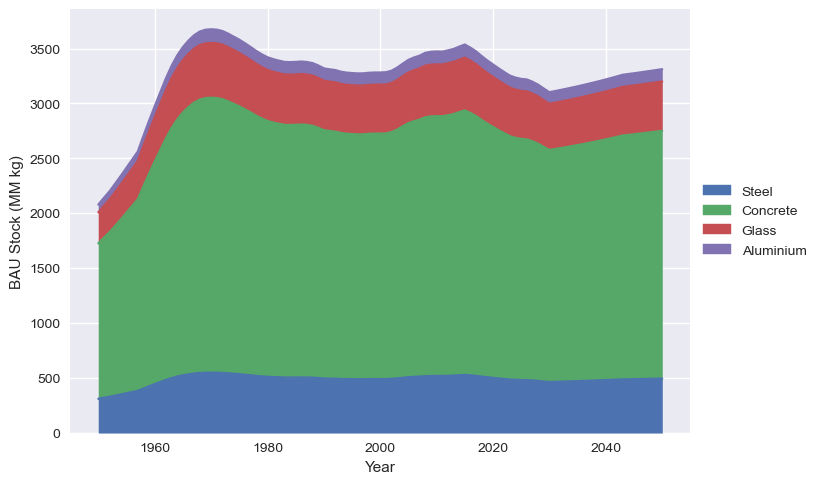

In [18]:
#9. D) Plot 4 different materials together under BAU scenario

# Graph 4 materials
four_materials = pd.DataFrame()
four_materials.index =  BAU_scenario_.index
four_materials['Steel'] = BAU_scenario_['Stock (MM kg)']
four_materials['Concrete'] = four_materials['Steel'] * (mi_concrete/mi_steel)
four_materials['Glass'] = four_materials['Steel'] * (mi_glass/mi_steel)
four_materials['Aluminium'] = four_materials['Steel'] * (mi_aluminium/mi_steel)

#plt.plot(BAU_scenario_['Stock (MM kg)'][:-29])
fig_four_materials = four_materials.plot(kind="area")
fig_four_materials.set_xlabel('Year')
fig_four_materials.set_ylabel('BAU Stock (MM kg)')
fig_four_materials.legend(loc='center left', bbox_to_anchor=(1, 0.5))

10.) Scenario 1: Increase yield/export ratio increase by 10% in 2050 compared to BAU. The government has asked to increase exports of greenhouse products to make up for decrease in other exports due to draught. They need to make the changes without improving yield rate and expand greenhouse surface area. 

<AxesSubplot:xlabel='Year'>

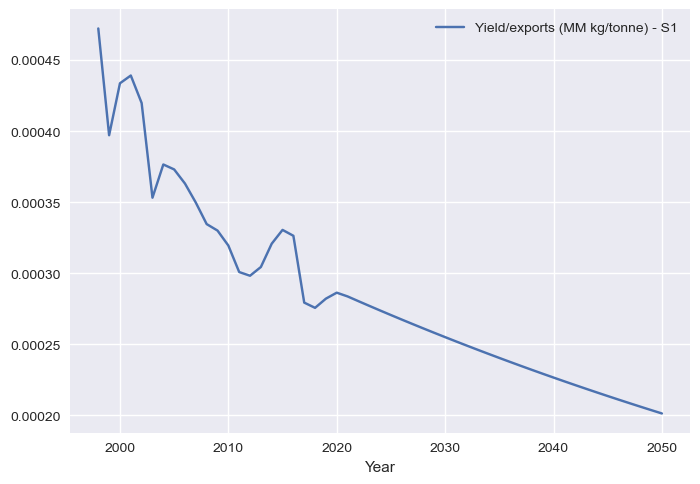

In [19]:
#10.A) Scenario 1: # Change yield data - Assumption that yield/export yield export rate will be 10% more compaired to 2050
BAU_scenario_2021 = BAU_scenario.loc[2021, 'Yield/exports (MM kg/tonne)'] 
BAU_scenario_2050 = BAU_scenario.loc[2050, 'Yield/exports (MM kg/tonne)']
BAU_scenario_2050_target = BAU_scenario_2050 * 1.1 # Set up target rate

years = 29 
decrease_rate = ((BAU_scenario_2050_target / BAU_scenario_2021) ** (1 / years)) - 1 #Set up decrease rate

# Create a list of new values with a new decrease
new_values = [BAU_scenario_2021 * (1 + decrease_rate) ** i for i in range(1, 30)]

# Create a DataFrame with the new values in a column called 'Value'
NL_vegetable_yield_exports_2022_2050_s1 = pd.DataFrame({'Yield/exports (MM kg/tonne) - S1': new_values})
NL_vegetable_yield_exports_2022_2050_s1['Year'] = pd.DataFrame({'Year': range(2022, 2051)})

NL_vegetable_yield_exports_1998_2021_s1 = NL_vegetable_yield_exports_1998_2021.copy()
NL_vegetable_yield_exports_1998_2021_s1.rename(columns={'Yield/exports (MM kg/tonne)': 'Yield/exports (MM kg/tonne) - S1'}, inplace=True)

# Concatenate the new DataFrame with the original DataFrame
NL_vegetable_yield_exports_1998_2050_s1 = pd.DataFrame()
NL_vegetable_yield_exports_1998_2050_s1 = pd.concat([NL_vegetable_yield_exports_1998_2021_s1, NL_vegetable_yield_exports_2022_2050_s1], ignore_index=True)
NL_vegetable_yield_exports_1998_2050_s1.plot(x= 'Year', y = ['Yield/exports (MM kg/tonne) - S1'])


In [20]:
#10.B) Scenario 1: Create the scenario dataframe
scenario_1 = BAU_scenario.copy()
scenario_1.name = 'Scenario 1'
#Modify Yield/Export ratio
scenario_1['Yield/exports (MM kg/tonne)'] = NL_vegetable_yield_exports_1998_2050_s1['Yield/exports (MM kg/tonne) - S1'].values

#Modify new yield = yield/export_S1 * exports_BAU
scenario_1['Yield (MM kg)'] = scenario_1['Yield/exports (MM kg/tonne)'] * BAU_scenario['Exports (tonne)']

#Modify new stock = (Yield / Stock)_BAU / yield_S1
scenario_1['Stock (MM kg)'] = (scenario_1['Yield (MM kg)'].values / BAU_scenario['Yield/stock (MM kg veg./MM kg steel structure)'].values)

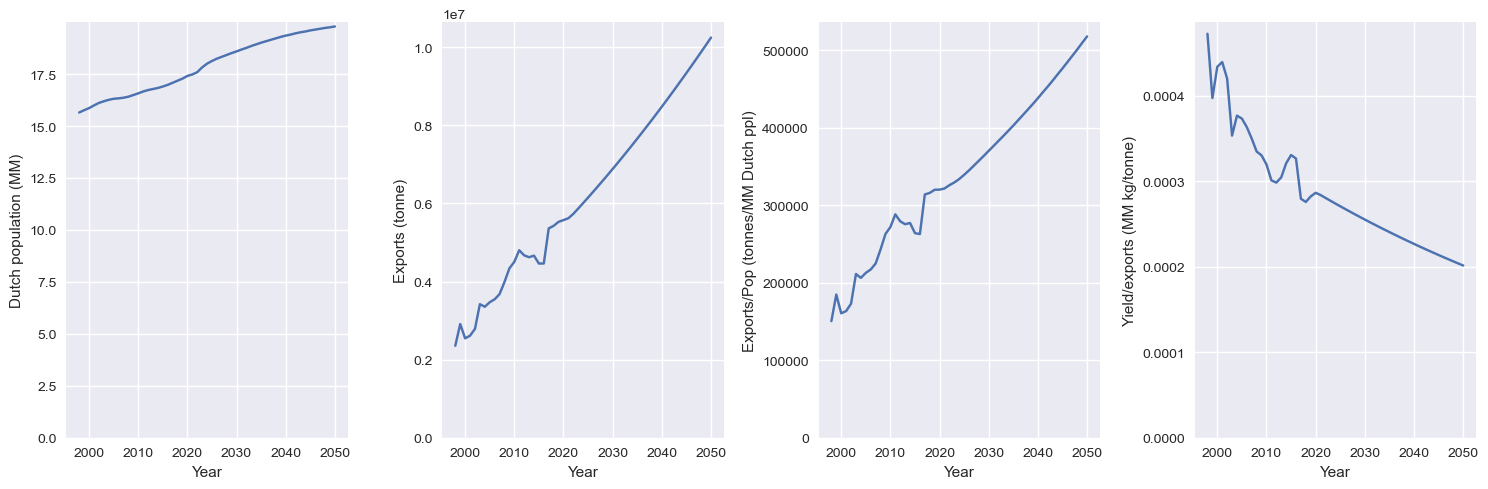

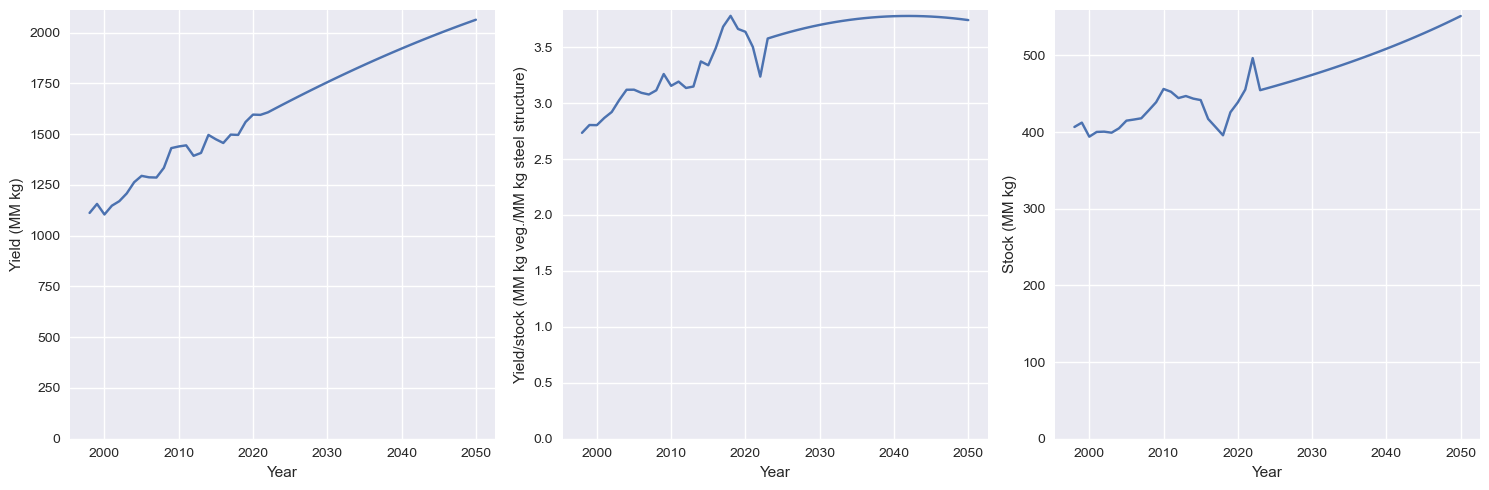

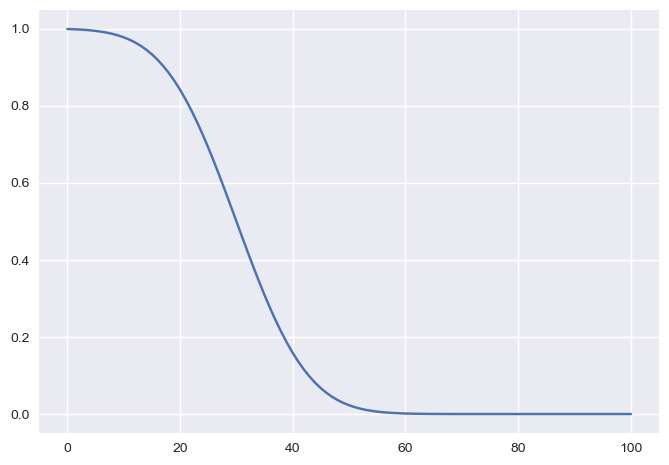

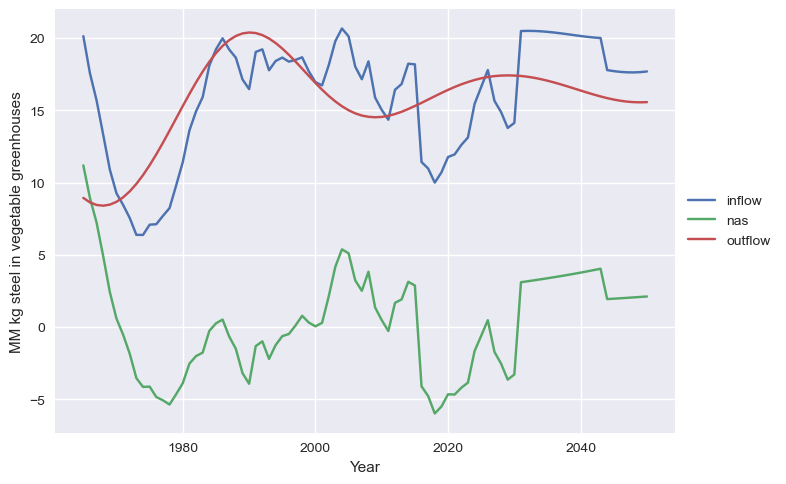

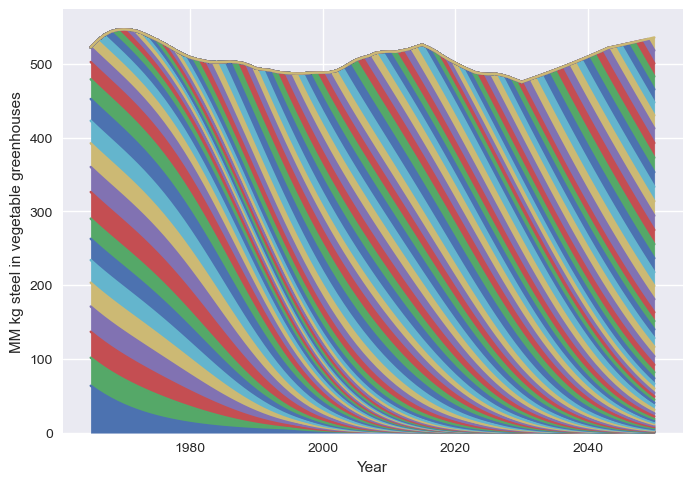

In [21]:
#10.C) Scenario 1: Plot and run strock driven model
#scenario_1['Stock (MM kg)'] = scenario_1['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()
plot_scenarios(scenario_1)

scenario_1_ = pd.DataFrame()
scenario_1_['Stock (MM kg)'] = pd.concat([(NL_gh_stock_data['Steel structure (kg) - Theurl - veg']/1000000), scenario_1['Stock (MM kg)'][-28:]], axis=0)
scenario_1_['Stock (MM kg)'] = scenario_1_['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()

s1_flow_timeseries, s1_fig_flows, s1_fig_cohorts = stock_driven_model(scenario_1_['Stock (MM kg)'], input_parameters, 1965, 'MM kg steel in vegetable greenhouses', 'Steel')

#11) Scenario 2: The Dutch government wants to reduce surface of greenhouses by 20% from 2021 levels by 2050, what must the improvement to yield rates be? Yield can not change

In [22]:
#11.A) Scenario 2: # Change stock trend for 2050 to reduce by 20% from 2021 levels

#Prepare new df copy
scenario_2 = BAU_scenario.copy()
scenario_2.name = 'Scenario 2'

BAU_scenario_2021 = BAU_scenario.loc[2021, 'Stock (MM kg)'] #2021 value
BAU_scenario_2050 = BAU_scenario_2021*.8 #Reduction of 2021 value by 20%
years = 29 
decrease_rate = ((BAU_scenario_2050 / BAU_scenario_2021) ** (1 / years)) - 1

# Create a list of new values with new decrease rate
new_values = [BAU_scenario_2021 * (1 + decrease_rate) ** i for i in range(1, 30)]

# Create a DataFrame with the new values and index labels
new_data = pd.DataFrame({'Stock (MM kg)': new_values}, index=range(2022, 2051))

# Concatenate the new data to the 'Stock (MM kg)' column of 'BAU_scenario'
scenario_2['Stock (MM kg)'] = pd.concat([scenario_2['Stock (MM kg)'][:-29], new_data['Stock (MM kg)']], axis=0)

In [23]:
#11.B) Scenario 2: Modify the scenario dataframe

#Modify new yield/stock ratio = 
scenario_2['Yield/stock (MM kg veg./MM kg steel structure)'] = BAU_scenario['Yield (MM kg)'].values / scenario_2['Stock (MM kg)'] 

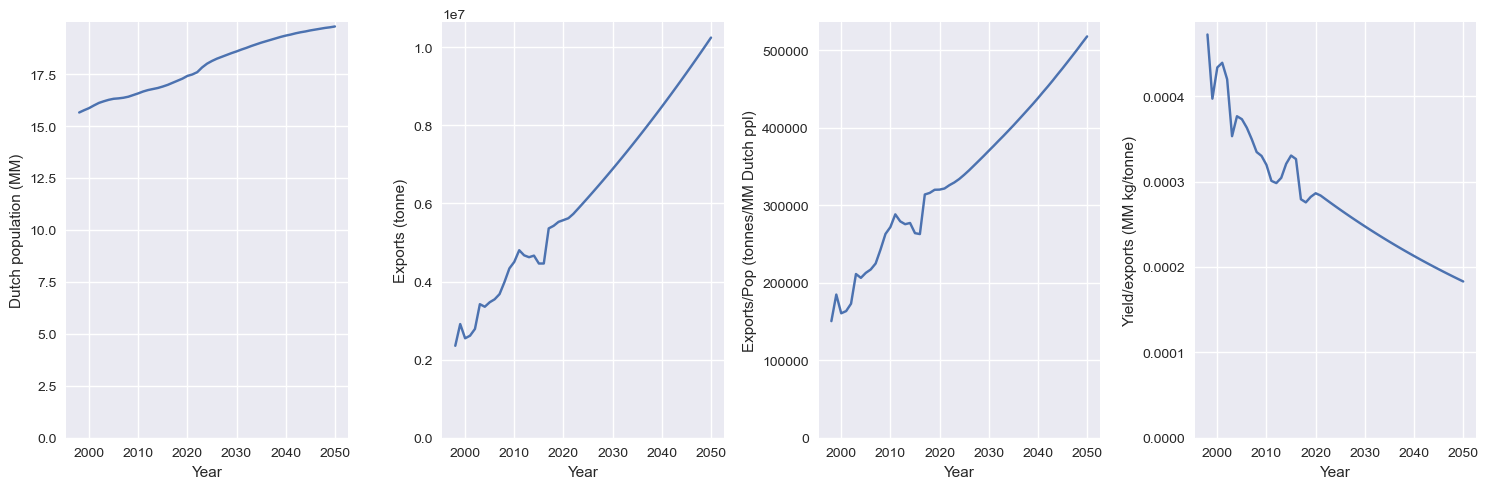

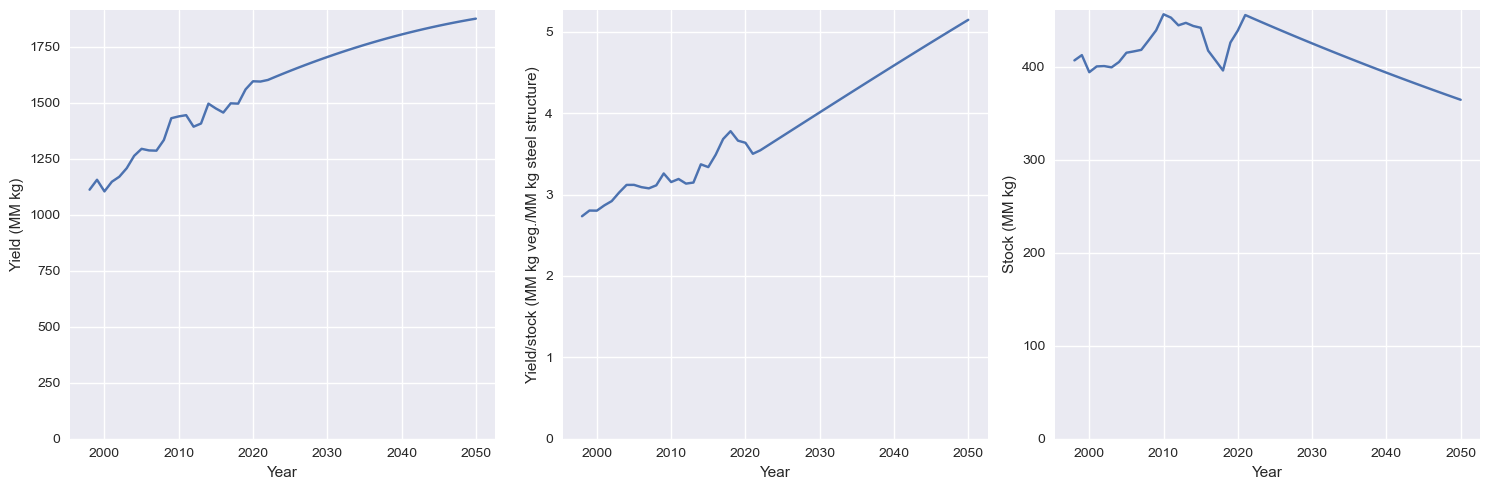

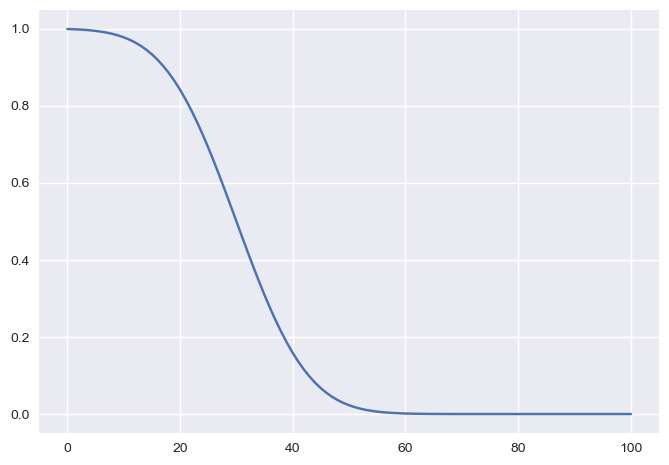

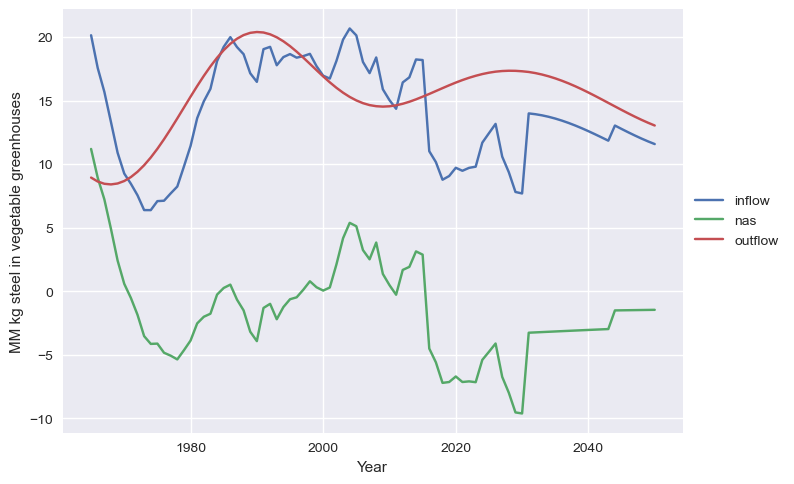

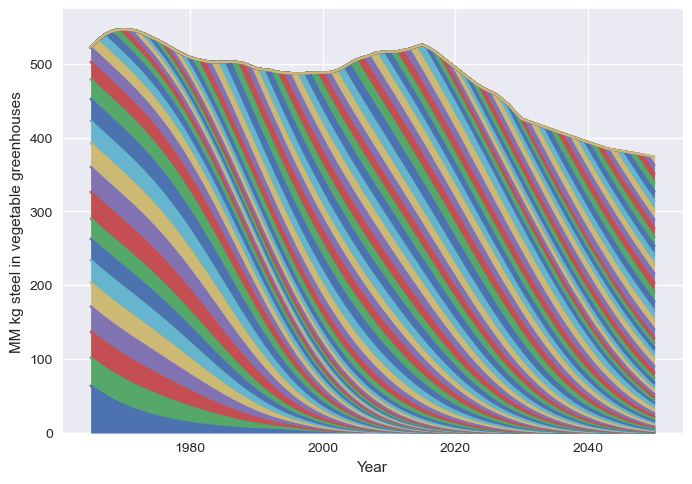

In [24]:
#11.C) Scenario 2: Plot and run strock driven model
#scenario_2['Stock (MM kg)'] = scenario_2['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()
plot_scenarios(scenario_2)

scenario_2_ = pd.DataFrame()
scenario_2_['Stock (MM kg)'] = pd.concat([(NL_gh_stock_data['Steel structure (kg) - Theurl - veg']/1000000), scenario_2['Stock (MM kg)'][-28:]], axis=0)
scenario_2_['Stock (MM kg)'] = scenario_2_['Stock (MM kg)'].rolling(15, center=True, min_periods=1).mean()

s2_flow_timeseries, s2_fig_flows, s2_fig_cohorts = stock_driven_model(scenario_2_['Stock (MM kg)'], input_parameters, 1965, 'MM kg steel in vegetable greenhouses', 'Steel')

12.) Compare 3 scenarios

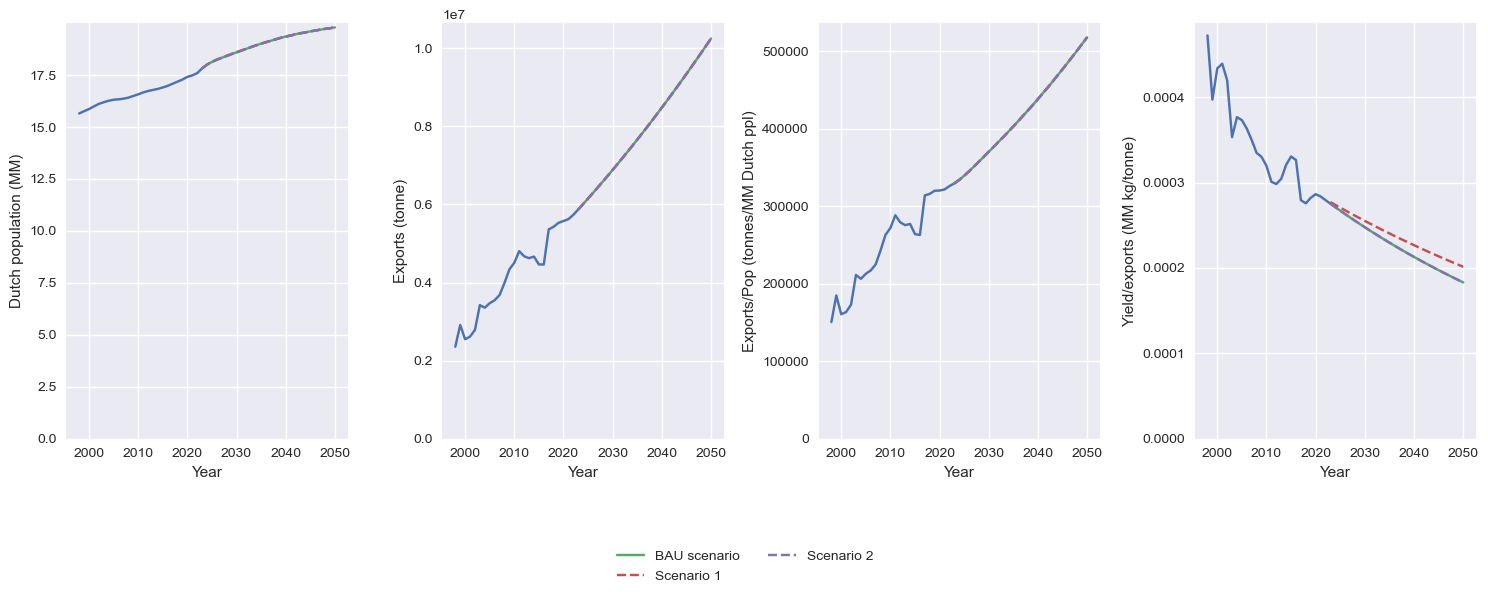

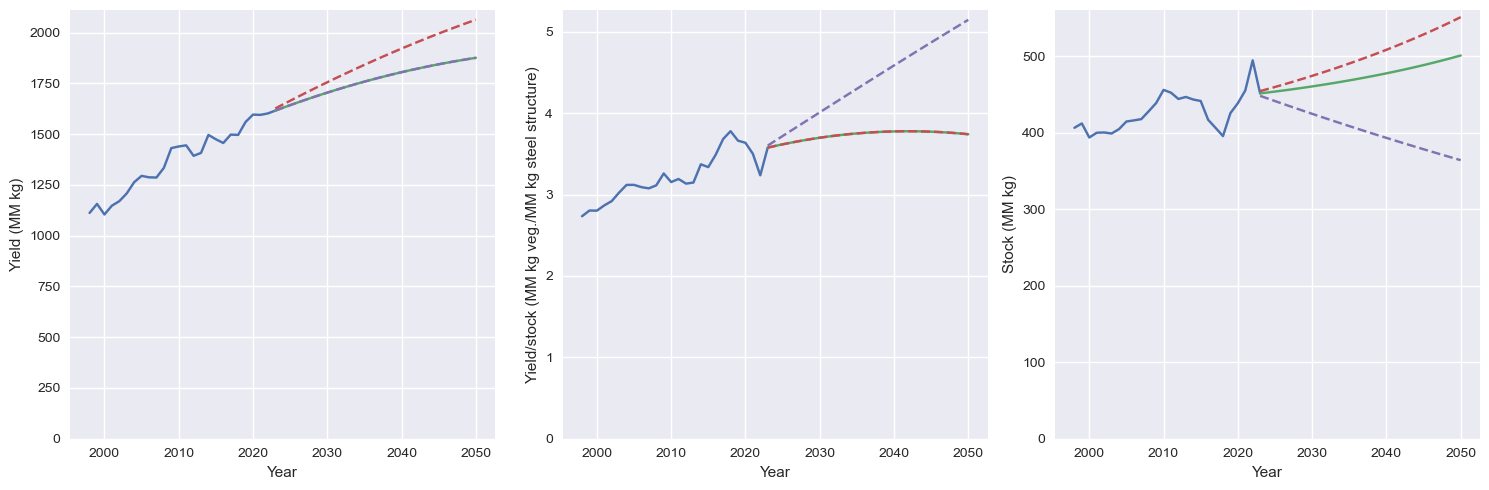

In [25]:
# 12. A) Compare 3 scenarios SDA
def plot_3scenarios(dataframe1, dataframe2, dataframe3):
    # Get the list of column names
    columns = dataframe1.columns

    # Plot the first four columns in the first figure
    fig1, axes1 = plt.subplots(1, 4, figsize=(15, 5))
        
    for i, column in enumerate(columns[:4]):
        ax = axes1[i]
        
        if i == 0:
           
            ax.plot(dataframe1.index[:-27], dataframe1[column][:-27]) #plot original data
            ax.plot(dataframe1.index[-28:], dataframe1[column][-28:], label=dataframe1.name) #plot BAU scenario
            
            ax.plot(dataframe2.index[-28:], dataframe2[column][-28:], linestyle='--', label=dataframe2.name) #plot scenario 1 with label
            ax.plot(dataframe3.index[-28:], dataframe3[column][-28:], linestyle='--', label=dataframe3.name) #plot scenario 2 with label
        
        else:
            ax.plot(dataframe1.index[:-27], dataframe1[column][:-27])
            ax.plot(dataframe1.index[-28:], dataframe1[column][-28:])
            
            ax.plot(dataframe2.index[-28:], dataframe2[column][-28:], linestyle='--')
            ax.plot(dataframe3.index[-28:], dataframe3[column][-28:], linestyle='--')
            
        ax.set_xlabel('Year')
        ax.set_ylabel(column)
        ax.set_ylim(0)  # Set the y-axis to start at 0
    
    fig1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.tight_layout()
    plt.show()
    
    # Plot the last three columns in the second figure
    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, column in enumerate(columns[-3:]):
        ax = axes2[i]
        
        if i == 0:
            ax.plot(dataframe1.index[:-27], dataframe1[column][:-27], label=dataframe1.name)
            ax.plot(dataframe1.index[-28:], dataframe1[column][-28:], label=dataframe1.name)
            ax.plot(dataframe2.index[-28:], dataframe2[column][-28:], linestyle='--', label=dataframe2.name)
            ax.plot(dataframe3.index[-28:], dataframe3[column][-28:], linestyle='--', label=dataframe3.name)
        
        else:
            ax.plot(dataframe1.index[:-27], dataframe1[column][:-27])
            ax.plot(dataframe1.index[-28:], dataframe1[column][-28:])
            ax.plot(dataframe2.index[-28:], dataframe2[column][-28:], linestyle='--')
            ax.plot(dataframe3.index[-28:], dataframe3[column][-28:], linestyle='--')
            
        ax.set_xlabel('Year')
        ax.set_ylabel(column)
        ax.set_ylim(0)  # Set the y-axis to start at 0
    plt.tight_layout()
    plt.show()
plot_3scenarios(BAU_scenario, scenario_1, scenario_2)

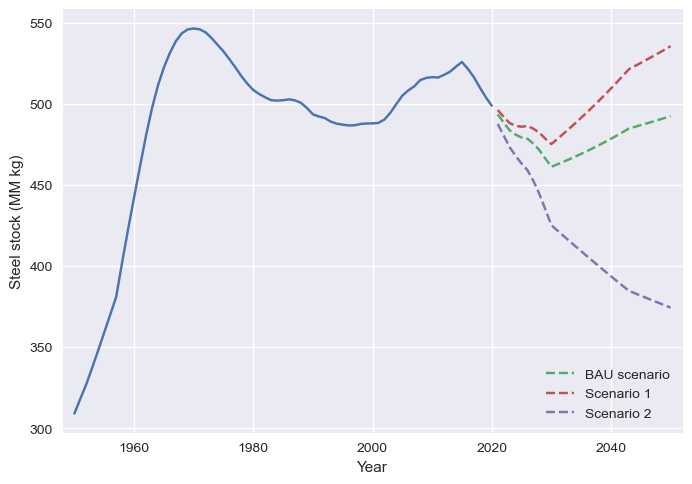

In [26]:
#12 B.) Compare only stock levels 

plt.plot(BAU_scenario_['Stock (MM kg)'][:-30])
#plt.plot(scenario_1_['Stock (MM kg)'][:-29])
#plt.plot(scenario_2_['Stock (MM kg)'][:-29])
plt.plot(BAU_scenario_['Stock (MM kg)'][-30:], label=BAU_scenario.name, linestyle='--')
plt.plot(scenario_1_['Stock (MM kg)'][-30:], label=scenario_1.name, linestyle='--')
plt.plot(scenario_2_['Stock (MM kg)'][-30:], label=scenario_2.name, linestyle='--')
plt.xlabel('Year')
plt.ylabel('Steel stock (MM kg)')
plt.xlim(1948,2052)
plt.legend()

13.) Prepare structural decomposition analysis

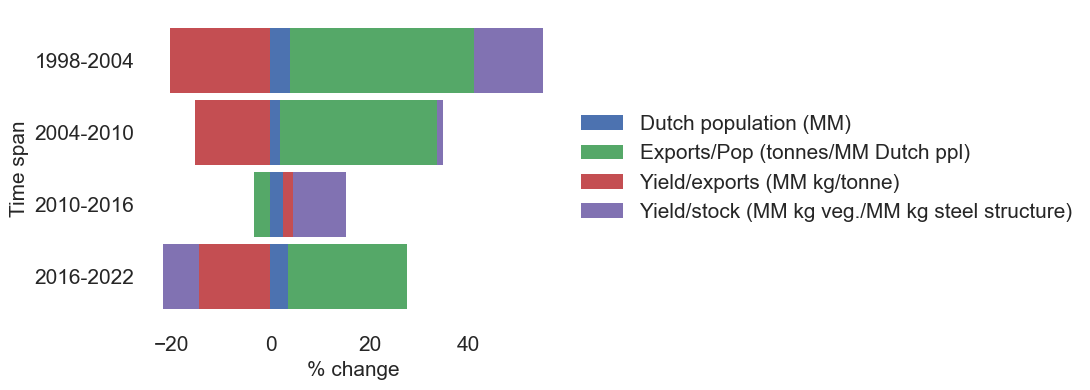

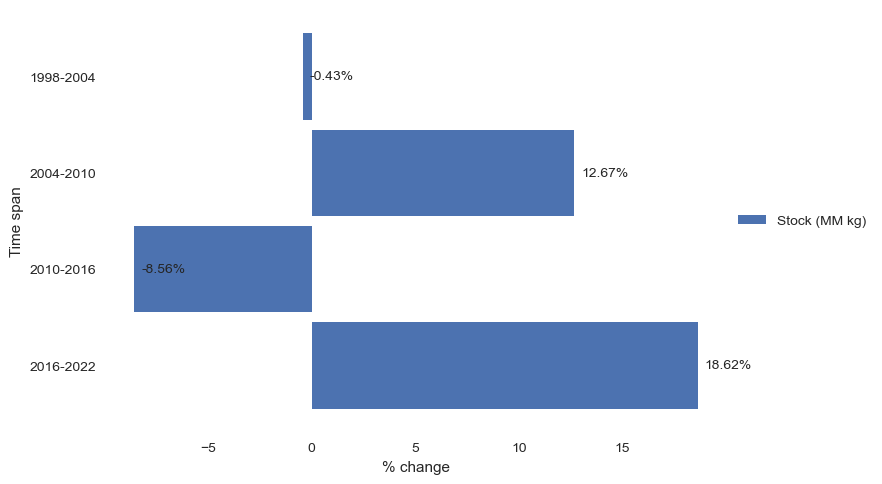

In [27]:

BAU_scenario_chart = BAU_scenario.copy()

BAU_IPAT = pd.DataFrame()

#'Stock (MM kg)'
BAU_IPAT['2016-2022'] = (BAU_scenario_chart.loc[2022] - BAU_scenario_chart.loc[2016]) * 100 / BAU_scenario_chart.loc[2016]
BAU_IPAT['2010-2016'] = (BAU_scenario_chart.loc[2016] - BAU_scenario_chart.loc[2010]) * 100 / BAU_scenario_chart.loc[2010]
BAU_IPAT['2004-2010'] = (BAU_scenario_chart.loc[2010] - BAU_scenario_chart.loc[2004]) * 100 / BAU_scenario_chart.loc[2004]
BAU_IPAT['1998-2004'] = (BAU_scenario_chart.loc[2004] - BAU_scenario_chart.loc[1998]) * 100 / BAU_scenario_chart.loc[1998]

BAU_IPAT_STOCK = BAU_IPAT.T[['Stock (MM kg)']]
BAU_IPAT = BAU_IPAT.T[['Dutch population (MM)','Exports/Pop (tonnes/MM Dutch ppl)', 'Yield/exports (MM kg/tonne)','Yield/stock (MM kg veg./MM kg steel structure)']]


# Adjust the figure size to make it more compact vertically
fig, ax = plt.subplots(figsize=(11, 4))  # Modify the figsize as per your preference

# Create the horizontal stacked bar chart
bars = BAU_IPAT.plot.barh(stacked=True, width=0.9, ax=ax)

# Set the axis labels with larger font size
ax.set_xlabel("% change", fontsize=15)  # Increase the fontsize value as needed
ax.set_ylabel('Time span', fontsize=15)  # Increase the fontsize value as needed

# Set the tick label font size
ax.tick_params(axis='both', which='major', labelsize=15)  # Increase the labelsize value as needed

# Set the legend outside the plot area with larger font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)  # Increase the fontsize value as needed

# Set the facecolor to None for a transparent background
ax.set_facecolor('None')

# Adjust the spacing between bars
ax.margins(y=0.01)  # Modify the value to adjust the spacing

plt.tight_layout()  # Adjusts the layout to prevent labels from being cut off


fig = BAU_IPAT_STOCK.plot.barh(stacked=True, width=0.9)
fig.set_xlabel("% change")
fig.set_ylabel('Time span')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_facecolor('None')

for container in fig.containers:
    for bar in container:
        width = bar.get_width()
        plt.annotate(f'{width:.2f}%', xy=(width, bar.get_y() + bar.get_height() / 2),
                     xytext=(5, 0), textcoords='offset points', va='center')


14) Comparison of inflows and outflows per decade under 3 scenarios

In [28]:
#14.A) Analyze inflows and outflows per decade 

bl_flow_decades = bl_flow_timeseries.copy()
s1_flow_decades = s1_flow_timeseries.copy()
s2_flow_decades = s2_flow_timeseries.copy()

bl_flow_decades.index = pd.to_datetime(bl_flow_decades.index, format='%Y')
s1_flow_decades.index = pd.to_datetime(s1_flow_decades.index, format='%Y')
s2_flow_decades.index = pd.to_datetime(s2_flow_decades.index, format='%Y')

# Group the data by decade and sum the values within each decade
bl_flow_decades = bl_flow_decades.groupby(pd.Grouper(freq='10Y')).sum()
bl_flow_decades = bl_flow_decades[['outflow', 'inflow']]

s1_flow_decades = s1_flow_decades.groupby(pd.Grouper(freq='10Y')).sum()
s1_flow_decades = s1_flow_decades[['outflow', 'inflow']]

s2_flow_decades = s2_flow_decades.groupby(pd.Grouper(freq='10Y')).sum()
s2_flow_decades = s2_flow_decades[['outflow', 'inflow']]

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, '')]

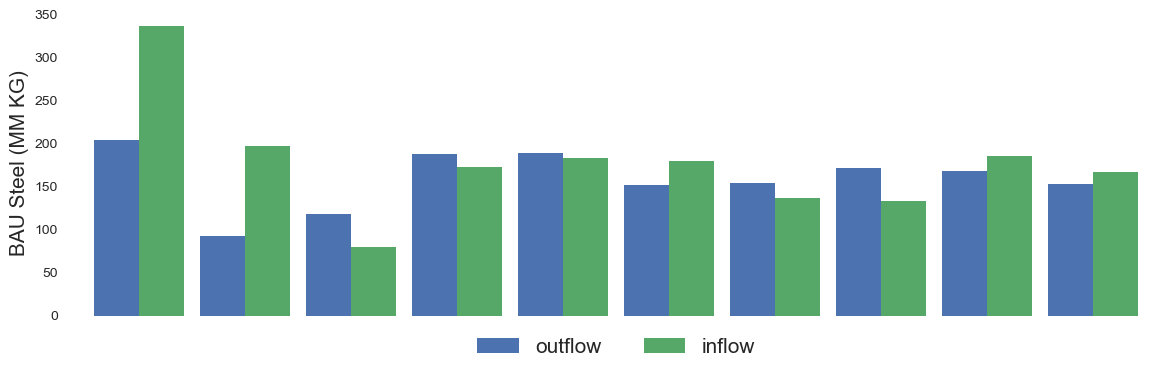

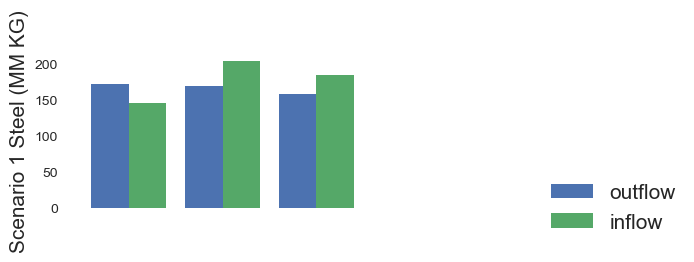

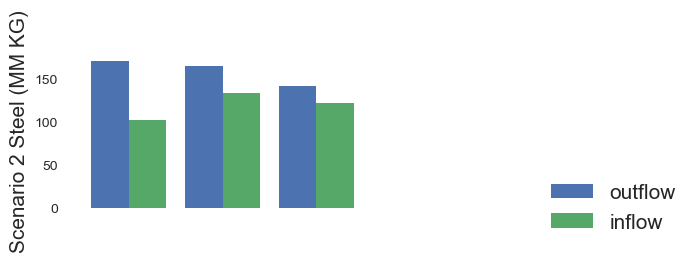

In [37]:
#14.B) Plot inflows and outflows

# Adjust the figure size and orientation for BAU scenario
fig, ax = plt.subplots(figsize=(12, 4))

# Create the vertical stacked bar chart
bars = bl_flow_decades[1:].plot.bar(stacked=False, width=0.85, ax=ax)

# Set the font size for all elements to 15
plt.rcParams.update({'font.size': 15})

# Set the y-axis label
ax.set_ylabel('BAU Steel (MM KG)', fontsize=15)

# Set the legend below the graph with 2 columns
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.01), ncol=2, fontsize=15)

# Set the facecolor to None for a transparent background
ax.set_facecolor('None')

# Remove the x-axis labels
ax.set_xticklabels([])

plt.tight_layout()

##

# Adjust the figure size and orientation for scenario S1
fig, ax = plt.subplots(figsize=(4, 2))

# Create the vertical stacked bar chart
bars = s1_flow_decades[-3:].plot.bar(stacked=False, width=0.8, ax=ax)

# Set the font size for all elements to 15
plt.rcParams.update({'font.size': 15})

# Set the y-axis label
ax.set_ylabel('Scenario 1 Steel (MM KG)', fontsize=15)

# Set the legend below the graph with 2 columns
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0), ncol=1, fontsize=15)

# Set the facecolor to None for a transparent background
ax.set_facecolor('None')

# Remove the x-axis labels
ax.set_xticklabels([])


##

# Adjust the figure size and orientation for scenario S2
fig, ax = plt.subplots(figsize=(4, 2))

# Create the vertical stacked bar chart
bars = s2_flow_decades[-3:].plot.bar(stacked=False, width=0.8, ax=ax)

# Set the font size for all elements to 15
plt.rcParams.update({'font.size': 15})

# Set the y-axis label
ax.set_ylabel('Scenario 2 Steel (MM KG)', fontsize=15)

# Set the legend below the graph with 2 columns
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0), ncol=1, fontsize=15)

# Set the facecolor to None for a transparent background
ax.set_facecolor('None')

# Remove the x-axis labels
ax.set_xticklabels([])

15. Uncertainty analysis - Montecarlo

In [30]:
#15.A) Prepare functions for MC analysis
def surv_curv_MC(data_set, parameters_df, material):
    # Prepare time series
    time_max = data_set.shape[0]  # the final timestep of this timeseries # max_life_steel #
    timesteps = np.arange(0, time_max)  # an array of the timesteps

    #Normally distributed survival curve
    curve_sd = parameters_df.loc[material, "standard_deviation"]
    curve_surv = scipy.stats.norm.sf(timesteps, parameters_df.loc[material, "mean"], scale=curve_sd)
    return curve_surv, time_max, timesteps

def stock_model_MC(data_set, curve_surv_matrix, plot_year, timesteps, material_units):
    stock_flow_timeseries = pd.DataFrame()
    stock_flow_timeseries.index = stock_flow_timeseries.index
    stock_flow_timeseries['stock'] = data_set
    stock_flow_timeseries['inflow'] = ''

    # create survival matrix with placeholder zeros
    cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps)
    stock_flow_timeseries['inflow'] = np.nan
    for time in timesteps:
        stock_flow_timeseries['inflow'].iloc[time] = (stock_flow_timeseries['stock'].iloc[time] - cohort_surv_matrix.loc[time, :].sum()) / curve_surv_matrix.loc[time, time]
        cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * stock_flow_timeseries['inflow'].iloc[time]

    cohort_surv_matrix.index = stock_flow_timeseries.index
    stock_flow_timeseries['nas'] = np.diff(stock_flow_timeseries['stock'], prepend=0)  # prepending 0 assumes no initial stock
    stock_flow_timeseries['outflow'] = stock_flow_timeseries['inflow'] - stock_flow_timeseries['nas']
    
    return stock_flow_timeseries


def stock_driven_model_MC(data_set, parameters_df, plot_year, material_units, material):
    curve_surv, time_max, timesteps = surv_curv_MC(data_set, parameters_df, material)
    curve_surv_matrix = surv_curve_matrix(curve_surv, time_max, timesteps)
    stock_flow_timeseries  = stock_model_MC(data_set, curve_surv_matrix, plot_year, timesteps, material_units)
    return stock_flow_timeseries

In [31]:
#15.B) Stock driven model for monte-carlo

# check that the function works, and how much time does it takes
run_time_start = datetime.now()
#point_estimate_results = flow_driven(dmc_data, input_parameters)
point_estimate_results = stock_driven_model_MC(BAU_scenario_['Stock (MM kg)'], input_parameters, 1950, 'MM kg steel in vegetable greenhouses', 'Steel')
run_time_stop = datetime.now()
run_time_delta = run_time_stop - run_time_start

# %% The Monte Carlo simulation

# set the number of runs for the Monte Carlo simulation
# Monte Carlo simulations involve hundreds or thousands of runs of the model
# HINT Be careful! according to run_time_delta, one run takes about 0.6 - 1 second on my computer
# so 200 runs will take 2-3 minutes, and 1000 runs could take 10-15 minutes
runs = 10000

# step 1: set up the randomization of the input values for the runs

# create a dataframe with random percent changes for the four input variables.
# We pre-compute this as a lookup table because calling the scipy random methods once is much faster than calling it at runtime again and again hundreds or thousands of times

randomize_vars = pd.DataFrame()
randomize_vars["stock"] = scipy.stats.uniform.rvs(loc=0.9, scale=0.2, size=runs)  # stocks will vary by a maximum of +/- 10%, with equal (uniform) probabilities of any value in between, because we're relatively confident about the original values
randomize_vars["mean"] = scipy.stats.uniform.rvs(loc=0.7, scale=0.6, size=runs)  # mean will vary by a maximum of +/- 30%, with equal (uniform) probabilities of any value in between, because we're not so confident about the original values
randomize_vars["standard_deviation"] = scipy.stats.uniform.rvs(loc=0.7, scale=0.6, size=runs)  # standard deviation will vary by a maximum of +/- 30%, with equal (uniform) probabilities of any value in between, because we're not so confident about the original values

# we chose to draw from uniform distributions to add lots of "noise" to the original input parameters.
# but if we're pretty confident about the original input parameters, we could draw from other more centralized distributions. e.g.
# randomize_vars["stock"] = scipy.stats.triang.rvs(c=0.5, loc=0.5, scale=1, size=runs)  # stock will vary by a maximum of +/- 50%, with a triangular probability
# randomize_vars["stock"] = scipy.stats.norm.rvs(loc=0, scale=0.2, size=10000)  # stock will vary with a normal distribution probability around the original values
# randomize_vars["stock"].plot(kind="hist")

# step 2: run the variant models
# The Monte Carlo simulation itself is a for loop that will traverse the randomized_vars dataframe's rows,
# each time taking the random value from that row and changing the input values accordingly
# and save the results in a dictionary of dataframes called monte_carlo_results
run_time_start = datetime.now()
monte_carlo_results = {}
for row in randomize_vars.index:
    BAU_scenario_rand = BAU_scenario_ * randomize_vars["stock"][row]
    input_parameters_rand = pd.DataFrame()
    input_parameters_rand['mean'] = input_parameters['mean'] * randomize_vars["mean"][row]
    input_parameters_rand['standard_deviation'] = input_parameters['standard_deviation'] * randomize_vars["standard_deviation"][row]
    monte_carlo_results[row] = stock_driven_model_MC(BAU_scenario_rand['Stock (MM kg)'], input_parameters_rand, 1950, 'MM kg steel in vegetable greenhouses', 'Steel')
    #print(row)  # just to show a life sign while this is running for a few minutes

run_time_stop = datetime.now()
run_time_delta = run_time_stop - run_time_start

# quite slow, see the bottom cell "making things faster with math: convolutions" for a faster implementation

# %% analyze the Monte Carlo results

# concatenate the Monte Carlo results to one monster dataframe
monte_carlo_results = pd.concat(monte_carlo_results.values(), keys=monte_carlo_results.keys(), axis=1)

# calculate statistics. We're mostly interested in the percentiles because we don't presume to know the distributions of the results, and don't expect them to be symmetrical, let alone a normal distribution, so the mean etc. might not be so informative
# create a pandas groupby() object to easily calculate statistics on the same result over the monte carlo runs
monte_carlo_results_grouped = monte_carlo_results.groupby(level=[1], axis=1)
# create a dictionary of dataframes for each statistic
monte_carlo_statistics = monte_carlo_results_grouped.quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
# TODO monte_carlo_statistics["mean"] = monte_carlo_results_grouped.mean()

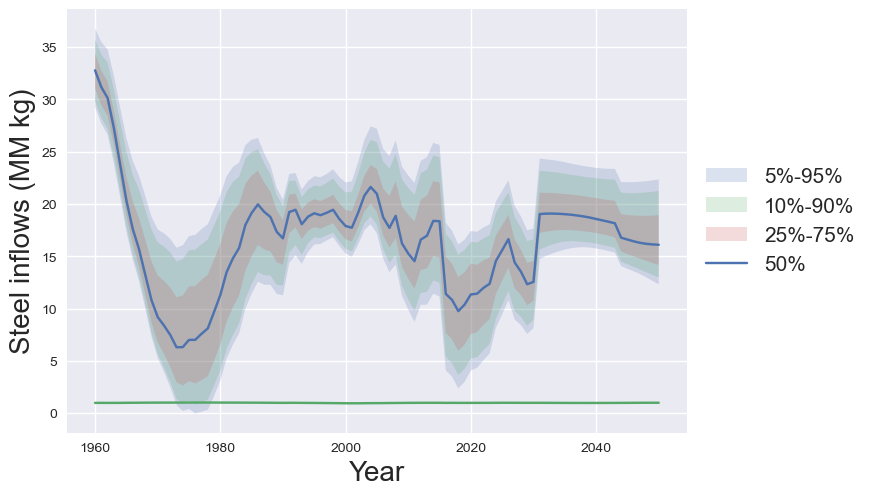

In [32]:
#15.C) Plot the monte carlo statistics - inflows
monte_carlo_flow = "inflow"
start_year = 1960
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.05)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.95)], alpha=0.2, label='5%-95%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.1)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.9)], alpha=0.2, label='10%-90%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.25)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.75)], alpha=0.2, label='25%-75%')
plt.plot(monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)], label='50%')

# note that the Monte Carlo results' central statistics (the median a.k.a. 50th percentile) don't exactly match the point estimates
plt.plot(point_estimate_results[monte_carlo_flow] / monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)])

plt.xlabel('Year', fontsize=20)
plt.ylabel('Steel inflows (MM kg)', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=15)

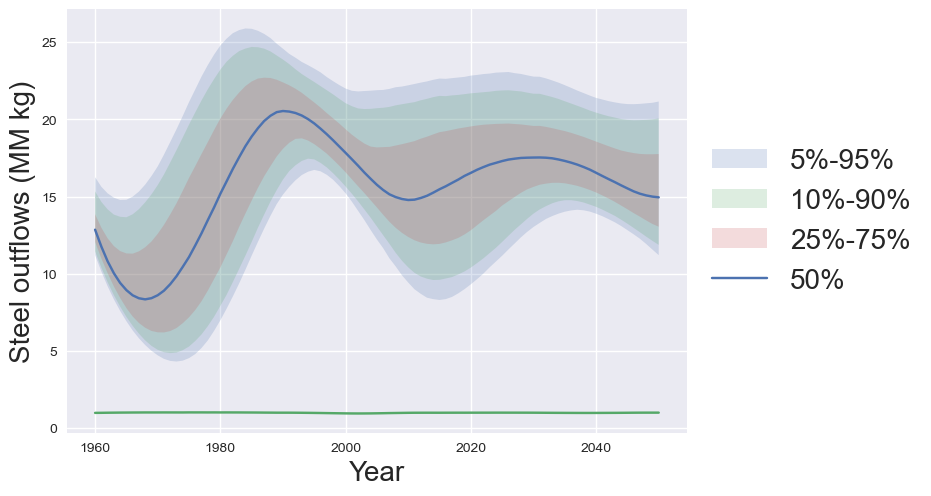

In [33]:
#15.D) Plot the monte carlo statistics - outflows
monte_carlo_flow = "outflow"
start_year = 1960
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.05)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.95)], alpha=0.2, label='5%-95%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.1)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.9)], alpha=0.2, label='10%-90%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.25)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.75)], alpha=0.2, label='25%-75%')
plt.plot(monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)], label='50%')

# note that the Monte Carlo results' central statistics (the median a.k.a. 50th percentile) don't exactly match the point estimates
plt.plot(point_estimate_results[monte_carlo_flow] / monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)])

plt.xlabel('Year', fontsize=20)
plt.ylabel('Steel outflows (MM kg)',fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=20)

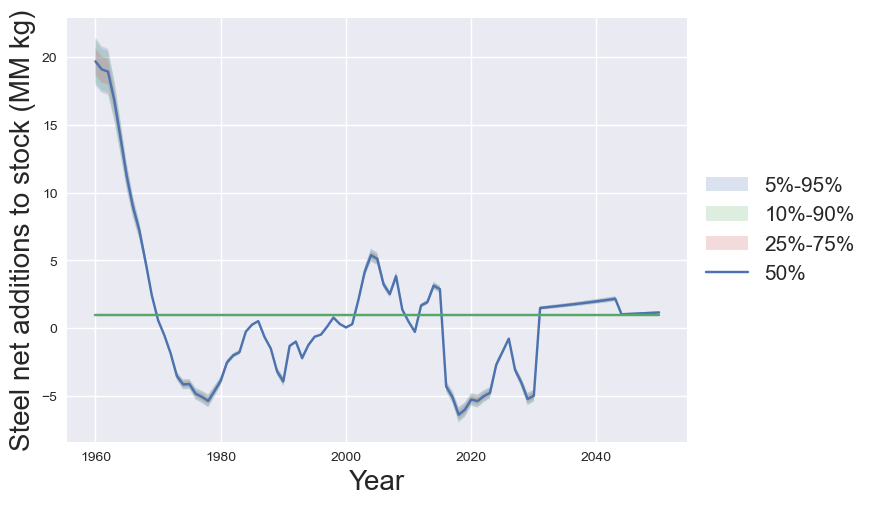

In [34]:
#15.E) Plot the monte carlo statistics - NAS
monte_carlo_flow = "nas"
start_year = 1960
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.05)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.95)], alpha=0.2, label='5%-95%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.1)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.9)], alpha=0.2, label='10%-90%')
plt.fill_between(x=monte_carlo_statistics.loc[start_year:].index, y1=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.25)], y2=monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.75)], alpha=0.2, label='25%-75%')
plt.plot(monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)], label='50%')

# note that the Monte Carlo results' central statistics (the median a.k.a. 50th percentile) don't exactly match the point estimates
plt.plot(point_estimate_results[monte_carlo_flow] / monte_carlo_statistics.loc[start_year:, (monte_carlo_flow, 0.5)])

plt.xlabel('Year', fontsize=20)
plt.ylabel('Steel net additions to stock (MM kg)', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=15)